# Creative Extension : Linguistic Harbingers of Betrayal

### CS-401 Applied Data Analysis - Fall 2020 semester

In [1]:
%matplotlib inline

import json
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression

In [2]:
from utils.preprocess_data import preprocessing, get_nb_msg, treat_msg_season
from utils.evaluation_utils import confidence_interval, evaluate_model
from utils.models import get_class_weights

# Getting the dataset

Let's get first the core object for our project, ***the data*** ! 

We will use here the dataset provided by the authors we will methods that can be found in `preprocess_data.py` to extract the features into a clean pandas frame.

In [3]:
data = pd.read_json("diplomacy_data/diplomacy_data.json")
df = preprocessing(data)
df.head()

sentiment_positive  sentiment_neutral  sentiment_negative  \
idx season                                                              
0   1906.5                   0                  0                   2   
    1906.5                   1                  1                   4   
    1906.5                   1                  2                   1   
    1906.5                   4                  2                  13   
    1906.5                   1                  3                   5   

            n_requests                                     frequent_words  \
idx season                                                                  
0   1906.5           1  [just, bot, ,, ., take, unit, war, retreat, di...   
    1906.5           2  [armies, north, the, armies, on, ., your, with...   
    1906.5           2  [?, going, for, ser, balance, a, to, of, give,...   
    1906.5           8  [only, he, alb, ., forced, italy's, is, be, .,...   
    1906.5           7  [more, let, keep, we, side, we, don't, to, ., ...   

            n_words  politeness  n_sentences  n_disc_words  \
idx season                                                   
0   1906.5       35    0.367200            2             7   
    1906.5       77    0.932326            6            16   
    1906.5       55    0.983373            4            14   
    1906.5      313    0.957072           19            71   
    1906.5      146    0.832023            9            38   

                                                   disc_words  \
idx season                                                      
0   1906.5  [just, war, prefer, really, light, retreat, in...   
    1906.5  [against, lose, even, loss, support, attack, g...   
    1906.5  [rather, light, would, lose, retreat, could, p...   
    1906.5  [so, so, before, while, before, still, as long...   
    1906.5  [before, still, move, ally, will, want, will, ...   

                                                    all_words      role  \
idx season                                                                
0   1906.5  [mos, prefer, retreat, in light of, of, turn, ...    victim   
    1906.5  [mos, moves, support, france, i'll, of, sounds...    victim   
    1906.5  [mos, retreat, supply, in light of, give, woul...    victim   
    1906.5  [go, support, while, ion, before, tun, each, w...    victim   
    1906.5  [support, before, don't, ., think, a, helping,...  betrayer   

            betrayal  season_betrayal  season_before_betrayal  \
idx season                                                      
0   1906.5      True           1909.5                     6.0   
    1906.5      True           1909.5                     6.0   
    1906.5      True           1909.5                     6.0   
    1906.5      True           1909.5                     6.0   
    1906.5      True           1909.5                     6.0   

            friendship_length  
idx season                     
0   1906.5                3.0  
    1906.5                3.0  
    1906.5                3.0  
    1906.5                3.0  
    1906.5                3.0

For understanding the data that we have, we first plot the distribution of seasons and understanding how many positive samples do we have.

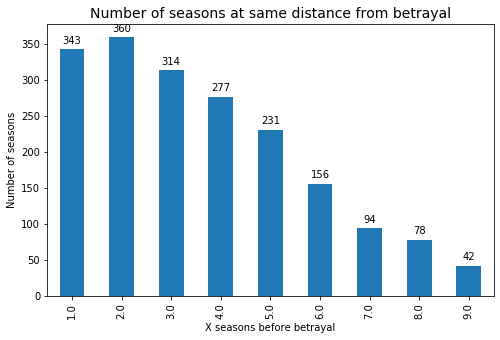

In [4]:
number_seasons_before_betrayal = df[(df["betrayal"]==True) & (df["role"] == "betrayer")].reset_index().groupby('season_before_betrayal').count()['idx']

plt.figure(figsize=(8, 5))
ax = number_seasons_before_betrayal.plot(kind='bar')
ax.set_xlabel("X seasons before betrayal")
ax.set_ylabel('Number of seasons')
ax.set_title('Number of seasons at same distance from betrayal', fontsize=14)
# ax.set_xticklabels(list(number_seasons_before_betrayal))

for rect, label in zip(ax.patches, list(number_seasons_before_betrayal)):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

plt.show()

There are 343 instances of 1 season before betrayal, 360 instances of 2 seasons before betrayal etc.

In [5]:
print('There is a number of {} seasons.'.format(np.sum(number_seasons_before_betrayal)))
print('There is an imbalance of {}'.format(number_seasons_before_betrayal.iloc[0] / np.sum(number_seasons_before_betrayal)))

There is a number of 1895 seasons.
There is an imbalance of 0.18100263852242743


# Predict Imminent Betrayal

We first try to predict better imminent betrayal. Our approach is similar to the authors in Section 5 to see if we can improve results and ensure corectness.

## Models

We explore using different models and pick up the best one! First, we will explore using:
* Logistic Regression
* Decision Trees: Random Forest
* Decision Trees: XGBoost
* Feed forward neural networks

### Prepare input data

Preprocess the data as described in the authors' paper.

In [6]:
features_data = df.copy()

# Consider only the betrayals relationships
features_data = features_data[features_data['betrayal'] == True]

# Drop words as we cannot consider as features here and betrayal infos
features_data = features_data.drop(columns=['frequent_words', 'all_words', 'season_betrayal', 'betrayal'])

aggreagted_features_per_season = features_data.groupby(['idx', 'season', 'role'], as_index=True).aggregate({
    'sentiment_positive': 'mean',
    'sentiment_neutral': 'mean',
    'sentiment_negative': 'mean',
    'n_requests': 'mean',
    'n_words': 'sum',
    'n_disc_words': 'sum',
    'politeness': 'mean',
    'n_sentences': 'sum',
    'friendship_length': 'min', # Same
    'season_before_betrayal': 'min' # Same
})

aggreagted_features_per_season.head()

sentiment_positive  sentiment_neutral  \
idx season role                                              
0   1906.5 betrayer            1.333333           1.333333   
           victim              1.500000           1.250000   
    1907.0 betrayer            0.142857           0.857143   
           victim              1.333333           0.666667   
    1907.5 betrayer            2.000000           2.500000   

                     sentiment_negative  n_requests  n_words  n_disc_words  \
idx season role                                                              
0   1906.5 betrayer            1.500000    3.666667      489           120   
           victim              5.000000    3.250000      480           108   
    1907.0 betrayer            1.285714    1.285714      280            46   
           victim              1.000000    0.666667       93            15   
    1907.5 betrayer            2.000000    5.500000      333            87   

                     politeness  n_sentences  friendship_length  \
idx season role                                                   
0   1906.5 betrayer    0.803328           25                3.0   
           victim      0.809993           31                3.0   
    1907.0 betrayer    0.560083           16                3.0   
           victim      0.785508            9                3.0   
    1907.5 betrayer    0.982703           13                3.0   

                     season_before_betrayal  
idx season role                              
0   1906.5 betrayer                     6.0  
           victim                       6.0  
    1907.0 betrayer                     5.0  
           victim                       5.0  
    1907.5 betrayer                     4.0

Expand the feature with the difference in politeness between victim and betrayer and with the difference in betrayals' politeness between current and previous season. Moreover, add the length of the friendship that we compute using the first and last support action.

In [7]:
features_per_season = aggreagted_features_per_season.reset_index()

# Add difference between politeness score in victim and betrayer
def delta_politeness(x):
    return {'delta_role_politeness': (x[x['role'] == 'betrayer']['politeness'].values - x[x['role'] == 'victim']['politeness'].values).item()}
delta_politeness_role = features_per_season.groupby(by=['idx', 'season']).apply(lambda x: pd.Series(delta_politeness(x))).reset_index()


def get_politeness_season(features_per_season):
    data_time = features_per_season.groupby(['idx']).apply(lambda x: pd.Series({
        'delta_time': x['politeness'].values - np.append(x['politeness'].values[0], x['politeness'].values[:-1])
}))
    delta_time_list = list()
    for dt in data_time['delta_time']:
        delta_time_list = np.append(delta_time_list, dt)
    return delta_time_list
features_per_season['delta_time_politeness'] = get_politeness_season(features_per_season)

# Consider just betrayer data
input_features = features_per_season[features_per_season['role'] == 'betrayer'].set_index(['idx', 'season']).join(delta_politeness_role.set_index(['idx', 'season'])).reset_index()

X = input_features[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative',  'n_requests', 'n_words', 'politeness', 'n_sentences', 'delta_role_politeness', 'delta_time_politeness', 'friendship_length']]
Y = (input_features['season_before_betrayal'] == 1.0).values.astype('float32')
X.head()

,sentiment_positive,sentiment_neutral,sentiment_negative,n_requests,n_words,politeness,n_sentences,delta_role_politeness,delta_time_politeness,friendship_length
0,1.333333,1.333333,1.500000,3.666667,489,0.803328,25,-0.006665,0.000000,3.0
1,0.142857,0.857143,1.285714,1.285714,280,0.560083,16,-0.225425,-0.249910,3.0
2,2.000000,2.500000,2.000000,5.500000,333,0.982703,13,0.375372,0.197195,3.0
3,1.800000,0.800000,2.200000,3.200000,449,0.748802,24,0.177667,0.141471,3.0
4,1.000000,1.000000,1.000000,2.000000,78,0.899161,6,0.335738,0.328027,3.0


### How we bootstrap model predictions

We use this method to assess performance on all the models that we train.

In [8]:
from scipy.stats import sem

def bootstrap_model_prediction(train_and_predict_fn, n_iterations, stratify, model_name):
    """Use to run the model for a number of iterations and get bootstrapped results."""

    print('Training model {}..'.format(model_name))

    f1_scores = []
    mmc_scores = []
    for i in range(n_iterations):

        # Split data before resampling
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42, shuffle=True)

        # Resample train and test data, stratifying on y (resulting in equal number of 0 and 1 labels)
        if stratify:
            x_train, y_train = resample(x_train, y_train, replace=True, stratify=y_train)
        else:
            x_train, y_train = resample(x_train, y_train, replace=True)

        x_test, y_test = resample(x_test, y_test, replace=True)

        scores = train_and_predict_fn(x_train, x_test, y_train, y_test)

        # We store the f1 and mmc scores only to compare to authors' baseline
        f1_scores.append(scores['f1'])
        mmc_scores.append(scores['mmc'])
    f1_score_low, f1_score_upper = confidence_interval(0.95, f1_scores)
    mmc_score_low, mmc_score_upper = confidence_interval(0.95, np.nan_to_num(mmc_scores))

    f1_avg_score, f1_avg_score_err = np.mean(f1_scores), sem(f1_scores)
    mmc_avg_score, mmc_avg_score_err = np.mean(mmc_scores), sem(mmc_scores)

    print('Average F1-Score: %.3f' % f1_avg_score)
    print('Average MMC-Score: %.3f' % mmc_avg_score)
    print('F1-Score: 95%% confidence interval %.3f and %.3f' % (f1_score_low, f1_score_upper))
    print('Matthews Corr Coef: 95%% confidence interval %.3f and %.3f' % (mmc_score_low, mmc_score_upper))

    return [f1_avg_score, f1_avg_score_err], [mmc_avg_score, mmc_avg_score_err]

In [9]:
all_models_f1_scores = []
all_models_mmc_scores = []
all_models_names = []

def add_results(f1_out, mmc_out, name):
    all_models_f1_scores.append(f1_out)
    all_models_mmc_scores.append(mmc_out)
    all_models_names.append(name)

### Logistic Regression

In [10]:
# How we select these features is explained below 
X = input_features[ ['sentiment_positive', 'sentiment_negative', 'n_requests', 'friendship_length']]

def train_and_predict_logistic_regressionl_normalized(x_train, x_test, y_train, y_test):
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    clf = LogisticRegression(random_state=0, class_weight=get_class_weights(Y)).fit(x_train, y_train)                                       
    y_pred = clf.predict(x_test)
    return evaluate_model(y_test, y_pred)

# Without stratifying
f1_output, mmc_output = bootstrap_model_prediction(train_and_predict_logistic_regressionl_normalized, 20, stratify=False, model_name="Logistic Regression (Nor)")

print("")
# With stratify
f1_output, mmc_output = bootstrap_model_prediction(train_and_predict_logistic_regressionl_normalized, 20, stratify=True, model_name="Logistic Regression (Nor)")
add_results(f1_output, mmc_output, "Logistic Regression")

Training model Logistic Regression (Nor)..
Average F1-Score: 0.460
Average MMC-Score: 0.298
F1-Score: 95% confidence interval 0.192 and 0.722
Matthews Corr Coef: 95% confidence interval -0.003 and 0.602

Training model Logistic Regression (Nor)..
Average F1-Score: 0.532
Average MMC-Score: 0.351
F1-Score: 95% confidence interval 0.375 and 0.740
Matthews Corr Coef: 95% confidence interval 0.118 and 0.632


### How we discovered the length of friendship matters

We look first to see whether different combinations of features can help to better predict our outcome.

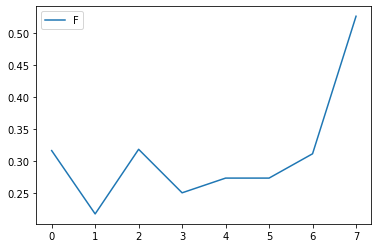

In [11]:
def log_reg_pipeline(features, print_=True):
    x_features = X[features].values
    x_train, x_test, y_train, y_test = train_test_split(x_features, Y, test_size=0.10, random_state=42)
    result = train_and_predict_logistic_regressionl_normalized( x_train, x_test, y_train, y_test)
    if print_:
        print("score on the test set : {}".format(result['f1']))
    return result['f1']

features_test = [
            ['politeness'],
            ['n_words', 'politeness', 'delta_role_politeness', 'delta_time_politeness'],
            ['n_words', 'politeness'],
            ['n_requests', 'n_words', 'politeness'],
            ['sentiment_positive', 'n_requests', 'n_words', 'politeness'],
            ['sentiment_positive', 'sentiment_neutral', 'n_requests', 'n_words', 'politeness'],
            ['sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'n_requests', 'n_words', 'politeness'],
            ['sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'n_requests', 'n_words', 'politeness', 'friendship_length'],
]

scores = []

for feature in features_test:
    score_nor = log_reg_pipeline(feature, False)
    scores.append(score_nor)
    
_ = plt.plot(np.arange(len(scores)), scores)
_ = plt.legend('F1 Score')

There is an evidence that including the friendship length can help for making the right decision ! Let's do a greedy search to cover as much possibilities as we can.

In [12]:
features_all = ['sentiment_positive', 'sentiment_neutral', 'sentiment_negative',  'n_words', 'politeness', 'n_requests', 'friendship_length', 'delta_time_politeness', 'delta_role_politeness']

In [13]:
from itertools import combinations

def greedy_search(X, features_all):
    list_features = []
    for i in range(len(features_all)):
        list_features += list(combinations(features_all, i+1))
    max_f1 = 0
    best_comb = ""
    for feat in list_features:
        features = [t for t in feat]
        x_features = X[features].values
        x_train, x_test, y_train, y_test = train_test_split(x_features, Y, test_size=0.10, shuffle=True, stratify=Y, random_state=42)
        result = train_and_predict_logistic_regressionl_normalized( x_train, x_test, y_train, y_test)
        if result["f1"] > max_f1:
            max_f1 = result["f1"]
            best_comb = features
    return max_f1, best_comb

In [14]:
max_f1, best_comb = greedy_search(X, features_all)
print("Best score : {} achieved with : {}".format(max_f1, best_comb))

Best score : 0.579 achieved with : ['sentiment_positive', 'sentiment_negative', 'n_requests', 'friendship_length']


### Decision Trees

#### Random Forest

We hypothesized that the lack of data can prevent the usefulness of deep trees and we considered that using a small depth (4) and a big number of estimators (1000) could perform better, thus getting the best model

In [15]:
from sklearn.ensemble import RandomForestClassifier

X = input_features[features]
Y = (input_features['season_before_betrayal'] == 1.0).values.astype(np.int)

def train_and_predict_random_forest(x_train, x_test, y_train, y_test):
    # Standardize data
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    # Train model
    clf = RandomForestClassifier(
        n_estimators=1000, 
        max_depth=4, 
        class_weight=get_class_weights(Y))
        
    # Predict
    clf.fit(x_train, y_train)

    # Evaluate
    y_pred = clf.predict(x_test)
    return evaluate_model(y_test, y_pred)

# Without
f1_output, mmc_output = bootstrap_model_prediction(train_and_predict_random_forest, 20, stratify=False, model_name="Random Forest")

print("")
# With stratify
f1_output, mmc_output = bootstrap_model_prediction(train_and_predict_random_forest, 20, stratify=True, model_name="Random Forest")
# add_results(f1_output, mmc_output, "Random Forest")

Training model Random Forest..
Average F1-Score: 0.347
Average MMC-Score: 0.282
F1-Score: 95% confidence interval 0.114 and 0.530
Matthews Corr Coef: 95% confidence interval 0.018 and 0.421

Training model Random Forest..
Average F1-Score: 0.589
Average MMC-Score: 0.504
F1-Score: 95% confidence interval 0.359 and 0.749
Matthews Corr Coef: 95% confidence interval 0.226 and 0.708


{'acc': 0.836,
 'f1': 0.593,
 'fn': 7,
 'fp': 4,
 'mmc': 0.49617,
 'precision': 0.667,
 'recall': 0.533,
 'tn': 48,
 'tp': 8}

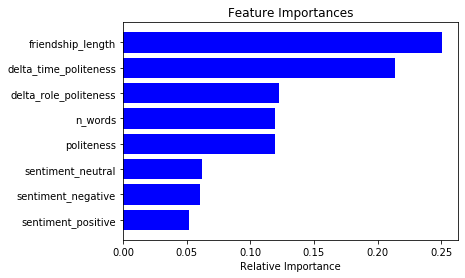

In [16]:
def train_rf_and_plot_importance(x_train, x_test, y_train, y_test ):
    # Standardize data
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # Train model
    clf = RandomForestClassifier(n_estimators=1000, max_depth=4, class_weight=get_class_weights(Y))
    clf.fit(x_train, y_train)

    importances = np.array(clf.feature_importances_)
    indices = np.argsort(importances)
    
    # Plot
    plt.figure(1)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), np.array(features)[indices])
    plt.xlabel('Relative Importance')

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)
train_rf_and_plot_importance(x_train, x_test, y_train, y_test)
train_and_predict_random_forest(x_train, x_test, y_train, y_test)

#### XGBoost

In [17]:
import xgboost

def train_and_predict_xgboost(x_train, x_test, y_train, y_test):
    # Standardize data
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    # Compute imbalance ratio
    ratio = float(np.sum(Y == 0)) / np.sum(Y == 1)
    
    # Train model
    clf = xgboost.XGBClassifier(n_jobs=-1, scale_pos_weight=ratio, n_estimators=300, max_depth=100)
    clf.fit(x_train, y_train)

    # Evaluate
    y_pred = clf.predict(x_test)
    return evaluate_model(y_test, y_pred)

# Without
f1_output, mmc_output = bootstrap_model_prediction(train_and_predict_xgboost, 20, stratify=False, model_name="XGBoost")

print("")
# With stratify
f1_output, mmc_output = bootstrap_model_prediction(train_and_predict_xgboost, 20, stratify=True, model_name="XGBoost")
# add_results(f1_output, mmc_output, "XGBoost")

Training model XGBoost..
Average F1-Score: 0.395
Average MMC-Score: 0.351
F1-Score: 95% confidence interval 0.301 and 0.530
Matthews Corr Coef: 95% confidence interval 0.192 and 0.506

Training model XGBoost..
Average F1-Score: 0.445
Average MMC-Score: 0.368
F1-Score: 95% confidence interval 0.216 and 0.625
Matthews Corr Coef: 95% confidence interval 0.163 and 0.569


### Feed Forward Neural Network

In [18]:
from utils.models import get_feed_forward_model, local_seed

BATCH_SIZE = 64
EPOCHS = 10
FEATURES_NUM = X.shape[-1]

model = get_feed_forward_model(FEATURES_NUM)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               4608      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 136,193
Trainable params: 136,193
Non-trainable params: 0
_________________________________________________________________


In [19]:
def train_and_predict_feed_forward_model(x_train, x_test, y_train, y_test):
    # Standardize
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    # Use to prevent overfitting by stopping training when validation loss decreases
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=3)

    # Compute the class weights to address the imabalance
    class_weights = get_class_weights(Y)
    with local_seed(10):
        model = get_feed_forward_model(X.shape[-1])
        result = model.fit(
            x_train, 
            y_train, 
            batch_size = BATCH_SIZE, 
            epochs=10,
            callbacks=[es],
            validation_data=(x_test, y_test),
            class_weight=class_weights, verbose=0)

    # Predict & evaluate
    y_pred = model.predict_step(x_test).numpy()
    y_pred_bool = y_pred > 0.5
    return evaluate_model(y_test, y_pred_bool)

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 10, test_size=0.2)
print(train_and_predict_feed_forward_model(x_train, x_test, y_train, y_test))

f1_output, mmc_output = bootstrap_model_prediction(train_and_predict_feed_forward_model, 20, stratify=True, model_name="Feedforward")
add_results(f1_output, mmc_output, "Feed Forward NN")

{'f1': 0.371, 'mmc': 0.093066, 'acc': 66.767, 'precision': 0.233, 'recall': 0.496, 'tp': 2046, 'fp': 6732, 'tn': 6834, 'fn': 2077}
Training model Feedforward..
Average F1-Score: 0.512
Average MMC-Score: 0.360
F1-Score: 95% confidence interval 0.348 and 0.658
Matthews Corr Coef: 95% confidence interval 0.185 and 0.540


# Plot model results

In [20]:
# Ading authors baseline, but considering the sem to be 0 
# since we do not have this information

all_models_f1_scores.append([0.31, 0])
all_models_mmc_scores.append([0.15, 0])
all_models_names.append('Authors baseline')

f1_scores  = np.array(all_models_f1_scores)
mmc_scores = np.array(all_models_mmc_scores)

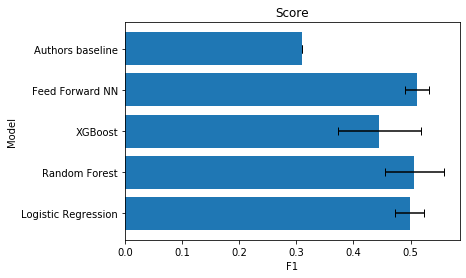

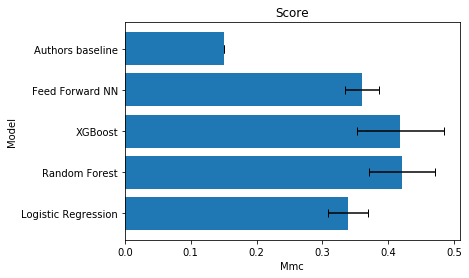

In [21]:
plt.barh(all_models_names, f1_scores[:, 0], xerr=f1_scores[:,1], capsize=4)
plt.title("Score")
plt.xlabel("f1".capitalize())
plt.ylabel("Model")
plt.show()

plt.barh(all_models_names, mmc_scores[:, 0], xerr=mmc_scores[:,1], capsize=4)
plt.title("Score")
plt.xlabel("mmc".capitalize())
plt.ylabel("Model")
plt.show()

# Explore more models using word embeddings

In [22]:
%%capture
!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')

### Get the new inputs: words embeddings

In [23]:
features_data = df.copy()

# Consider only the betrayals relationships
features_data = features_data[features_data['betrayal'] == True]
features_data = features_data.drop(columns=[ 'season_betrayal', 'betrayal'])

aggreagted_features_per_season = features_data.groupby(['idx', 'season', 'role'], as_index=True).aggregate({
    'sentiment_positive': 'mean',
    'sentiment_neutral': 'mean',
    'sentiment_negative': 'mean',
    'n_requests': 'mean',
    'n_words': 'sum',
    'n_disc_words': 'sum',
    'politeness': 'mean',
    'n_sentences': 'sum',
    'friendship_length': 'min', # Same
    'season_before_betrayal': 'min', # Same
     'all_words': 'sum' # Adding all words in a season
})

features_per_season = aggreagted_features_per_season.reset_index()

# Add difference politeness deltas
delta_politeness_role = features_per_season.groupby(by=['idx', 'season']).apply(lambda x: pd.Series(delta_politeness(x))).reset_index()
features_per_season['delta_time_politeness'] = get_politeness_season(features_per_season)

# Consider just betrayer data
input_features = features_per_season[features_per_season['role'] == 'betrayer'].set_index(['idx', 'season']).join(delta_politeness_role.set_index(['idx', 'season'])).reset_index()

X = input_features
Y = (input_features['season_before_betrayal'] == 1.0).values.astype('float32')
X.head()

,idx,season,role,sentiment_positive,sentiment_neutral,sentiment_negative,n_requests,n_words,n_disc_words,politeness,n_sentences,friendship_length,season_before_betrayal,all_words,delta_time_politeness,delta_role_politeness
0,0,1906.5,betrayer,1.333333,1.333333,1.500000,3.666667,489,120,0.803328,25,3.0,6.0,"[sure, retreat, and, something, enemy, decide,...",0.000000,-0.006665
1,0,1907.0,betrayer,0.142857,0.857143,1.285714,1.285714,280,46,0.560083,16,3.0,5.0,"[the, a, are, game, france, new, ?, or, all, ,...",-0.249910,-0.225425
2,0,1907.5,betrayer,2.000000,2.500000,2.000000,5.500000,333,87,0.982703,13,3.0,4.0,"[and, will, stp, tus, advance, shall, next, ma...",0.197195,0.375372
3,0,1908.0,betrayer,1.800000,0.800000,2.200000,3.200000,449,117,0.748802,24,3.0,3.0,"[a, hope, turkey, figure, out, ., for, they, s...",0.141471,0.177667
4,0,1908.5,betrayer,1.000000,1.000000,1.000000,2.000000,78,24,0.899161,6,3.0,2.0,"[a, but, ?, suggestions, little, hello, ,, am,...",0.328027,0.335738


In [24]:
from utils.text_preprocessing_utils import clean_words

# Words combined look like this
print('Before cleaning:')
print(X['all_words'][70][:50])
print("")

# We notice multiple stop words need to be removed, as well as contractions and very short, non-understanble words under3 characters
X['all_words'] = X['all_words'].map(clean_words)

print('After cleaning')
print(X['all_words'][70][:50])

Before cleaning:
['the', 'missed', 'a', 'others', 'and', 'are', 'making', "can't", 'bur', 'us', 'supply', 'happy', 'which', 'just', ',', "i'll", 'would', "i'm", '.', 'nth', 'fine', 'dmz', 'mun', 'offensive', 'key', 'swe', 'though', 'centers', "it's", 'that', 'back', 'your', 'from', 'its', 'make', 'on', 'territories', 'not', 'in', 'ruh', '2', 'planning', 'be', 'stabbing', 'both', 'spring', 'i', 'to', "'", '&']

After cleaning
['missed', 'others', 'making', 'supply', 'happy', 'would', 'fine', 'offensive', 'though', 'centers', 'back', 'make', 'territories', 'planning', 'stabbing', 'spring', 'part', 'away', 'austria', 'apologies', 'means', 'fleets', 'email', 'assure', 'move']


Max number of words per season 762
Mean number of words per season 65.10859728506787
Min number of words per season 0
Number of unique words are 1992


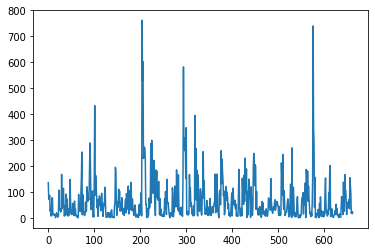

In [25]:
total_words_per_season = [len(X['all_words'][i]) for i in range(X.shape[0])]
print('Max number of words per season', np.max(total_words_per_season))
print('Mean number of words per season', np.mean(total_words_per_season))
print('Min number of words per season', np.min(total_words_per_season))
from utils.text_preprocessing_utils import read_glove_embeddings
all_words = []
for idx in range(X.shape[0]):
    all_words = all_words + X['all_words'][idx]
print('Number of unique words are', len(set(all_words)))

plt.plot(total_words_per_season)
plt.show()

# Based on the following, we decide to pad/truncate to max 200 words and use an embedding matrix of 2140 words.

In [26]:
from utils.text_preprocessing_utils import read_glove_embeddings, compute_relevant_embedding_matrix

EMBEDDING_DIM = 25
MAX_WORDS = 2147
MAX_LEN = 200

# Load the embeddings from Glove lowest dimensional trained embeddings
embeddings = read_glove_embeddings('../glove.twitter.27B.25d.txt')

# Get the matrix fo embeddings and mapping of words to rows in the embeddings matrix
embedding_matrix, map_word_to_idx = compute_relevant_embedding_matrix(embeddings, all_words, MAX_WORDS,  EMBEDDING_DIM)

def convert_word_to_id(words):
    return [map_word_to_idx[w] for w in words if w in map_word_to_idx]

# Convert the words to their idx in the matrix
X['all_words'] = X['all_words'].map(convert_word_to_id)

Embeddings containing 1193514 word vectors.


## Fusion model between numerical and embeddings

In [27]:
from utils.models import get_embedding_submodel, get_numerical_submodel, get_combined_model

tf.keras.backend.clear_session()
model_embedding = get_embedding_submodel( MAX_LEN, MAX_WORDS, EMBEDDING_DIM, embedding_matrix)

# The model to contain the embeddings
print("Embeddings model")
model_embedding.summary()

Embeddings model
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emb_input (InputLayer)       [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 25)           53675     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                23040     
Total params: 76,715
Trainable params: 23,040
Non-trainable params: 53,675
_________________________________________________________________


In [28]:
model_numerical = get_numerical_submodel(10)

# The model to contain the numerical values
print("Numerical model")
model_numerical.summary()

Numerical model
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
num_input (InputLayer)       [(None, 10)]              0         
_________________________________________________________________
num_dense (Dense)            (None, 64)                704       
Total params: 704
Trainable params: 704
Non-trainable params: 0
_________________________________________________________________


In [29]:
from utils.models import get_numerical_model_x_inputs, get_embeddings_model_x_inputs, local_seed

def train_and_predict_fusion_model(x_train, x_test, y_train, y_test):
    x_train_1, x_test_1 = get_embeddings_model_x_inputs(x_train, x_test, MAX_LEN)
    x_train_2, x_test_2 = get_numerical_model_x_inputs(x_train, x_test)

    with local_seed(10):
        tf.keras.backend.clear_session()
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=3)

        class_weights = get_class_weights(Y)
        model = get_combined_model(model_embedding, model_numerical)
        result = model.fit({'input_1': x_train_1, 'input_2': x_train_2},
            y_train, 
            batch_size = 32, 
            epochs=10,
            callbacks=[es],
            validation_data=({'input_1': x_test_1, 'input_2': x_test_2}, y_test),
            class_weight=class_weights, verbose=0)

    y_pred = model.predict_step({'input_1': x_test_1, 'input_2': x_test_2}).numpy()
    y_pred_bool = y_pred > 0.5
    return evaluate_model(y_test, y_pred_bool)


x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 10, stratify=Y, test_size=0.2, shuffle=True)
train_and_predict_fusion_model(x_train, x_test, y_train, y_test )

# f1_output, mmc_output = bootstrap_model_prediction(train_and_predict_fusion_model, 10, stratify=True, model_name="Fusion model")
# print('Average f1', f1_output[0])
# print('Average mmc', mmc_output[0])

{'acc': 76.549,
 'f1': 0.395,
 'fn': 2158,
 'fp': 5350,
 'mmc': 0.204542,
 'precision': 0.195,
 'recall': 0.376,
 'tn': 8881,
 'tp': 1300}

# How early can we predict betrayal?

## Two seasons before betrayal

Our method to see if we can predict betrayal considering a window size of two seasons:
- we move back in time in each relationship at the point all relationships are two seasons away from betrayal
- we label all seasons that are two seasons away of betrayal with the with the imminent outcome and the rest with 0

In [30]:
f1_scores =[]
mmc_scores = []

In [31]:
input_features_before = input_features[input_features['season_before_betrayal'] >= 2]

X = input_features_before[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'n_requests', 'n_words', 
               'n_sentences', 'politeness', 'delta_role_politeness', 'delta_time_politeness', 'friendship_length']]

# Going back in time requires updating the length of friendship
X['friendship_length'] = X['friendship_length'] - 2
Y = (input_features_before['season_before_betrayal'] == 2.0).values.astype('float32')
X.head()

,sentiment_positive,sentiment_neutral,sentiment_negative,n_requests,n_words,n_sentences,politeness,delta_role_politeness,delta_time_politeness,friendship_length
0,1.333333,1.333333,1.500000,3.666667,489,25,0.803328,-0.006665,0.000000,1.0
1,0.142857,0.857143,1.285714,1.285714,280,16,0.560083,-0.225425,-0.249910,1.0
2,2.000000,2.500000,2.000000,5.500000,333,13,0.982703,0.375372,0.197195,1.0
3,1.800000,0.800000,2.200000,3.200000,449,24,0.748802,0.177667,0.141471,1.0
4,1.000000,1.000000,1.000000,2.000000,78,6,0.899161,0.335738,0.328027,1.0


In [32]:
f1_score, mmc_score = bootstrap_model_prediction(train_and_predict_logistic_regressionl_normalized, 20, stratify=True, model_name="")

Training model ..
Average F1-Score: 0.453
Average MMC-Score: 0.256
F1-Score: 95% confidence interval 0.295 and 0.648
Matthews Corr Coef: 95% confidence interval -0.010 and 0.506


In [33]:
bootstrap_model_prediction(train_and_predict_random_forest, 20, stratify=True, model_name="")
f1_scores.append(f1_score[0])
mmc_scores.append(mmc_score[0])

Training model ..
Average F1-Score: 0.542
Average MMC-Score: 0.439
F1-Score: 95% confidence interval 0.304 and 0.867
Matthews Corr Coef: 95% confidence interval 0.112 and 0.840


## Three seasons before betrayal

In [34]:
input_features_before = input_features[input_features['season_before_betrayal'] >= 3]

X = input_features_before[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'n_requests', 'n_words', 
               'n_sentences', 'politeness', 'delta_role_politeness', 'delta_time_politeness', 'friendship_length']]
X['friendship_length'] = X['friendship_length']  - 3
Y = (input_features_before['season_before_betrayal'] == 3.0).values.astype('float32')

In [35]:
_, _ = bootstrap_model_prediction(train_and_predict_logistic_regressionl_normalized, 20, stratify=True, model_name="")

Training model ..
Average F1-Score: 0.308
Average MMC-Score: 0.108
F1-Score: 95% confidence interval 0.079 and 0.478
Matthews Corr Coef: 95% confidence interval -0.170 and 0.335


In [36]:
bootstrap_model_prediction(train_and_predict_random_forest, 20, stratify=True, model_name="")
f1_scores.append(f1_score[0])
mmc_scores.append(mmc_score[0])

Training model ..
Average F1-Score: 0.589
Average MMC-Score: 0.512
F1-Score: 95% confidence interval 0.174 and 0.817
Matthews Corr Coef: 95% confidence interval 0.031 and 0.786


## Four seasons before betrayal

In [37]:
input_features_before = input_features[input_features['season_before_betrayal'] >= 4]

X = input_features_before[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'n_requests', 'n_words', 
               'n_sentences', 'politeness', 'delta_role_politeness', 'delta_time_politeness', 'friendship_length']]
X['friendship_length'] = X['friendship_length'] - 4
Y = (input_features_before['season_before_betrayal'] == 4.0).values.astype('float32')

In [38]:
_, _ = bootstrap_model_prediction(train_and_predict_logistic_regressionl_normalized, 20, stratify=True, model_name="Logistic Regr")

Training model Logistic Regr..
Average F1-Score: 0.442
Average MMC-Score: 0.346
F1-Score: 95% confidence interval 0.073 and 0.784
Matthews Corr Coef: 95% confidence interval -0.029 and 0.746


In [39]:
bootstrap_model_prediction(train_and_predict_random_forest, 20, stratify=True, model_name="")
f1_scores.append(f1_score[0])
mmc_scores.append(mmc_score[0])

Training model ..


Average F1-Score: 0.417
Average MMC-Score: nan
F1-Score: 95% confidence interval 0.000 and 0.825
Matthews Corr Coef: 95% confidence interval -0.084 and 0.777


# Let's help the player win!

We want to see if we can better predict with confidence the probability of a player to be betrayed in the future considering more than the previous season before betrayal, as we saw that betrayer show sublte signs and changes in behaviour prior to the last season of friendship, implying they might have a long-time horizon strategy within the game.

### Using two seasons up to betrayal

In [40]:
X = input_features[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'n_requests', 'n_words', 
               'n_sentences', 'politeness', 'delta_role_politeness', 'delta_time_politeness']]
Y = (input_features['season_before_betrayal']  <= 2.0).values.astype('int')

In [41]:
f1_scores, mmc_scores = bootstrap_model_prediction(train_and_predict_logistic_regressionl_normalized, 20, stratify=True, model_name="Logistic Regr")

Training model Logistic Regr..
Average F1-Score: 0.629
Average MMC-Score: 0.356
F1-Score: 95% confidence interval 0.451 and 0.827
Matthews Corr Coef: 95% confidence interval 0.077 and 0.675


In [42]:
f1_scores, mmc_scores =  bootstrap_model_prediction(train_and_predict_random_forest, 4, stratify=False, model_name="Random Forest")

Training model Random Forest..
Average F1-Score: 0.600
Average MMC-Score: 0.360
F1-Score: 95% confidence interval 0.548 and 0.664
Matthews Corr Coef: 95% confidence interval 0.279 and 0.456


### Using three seasons up to betrayal

In [43]:
X = input_features[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'n_requests', 'n_words', 
               'n_sentences', 'politeness', 'delta_role_politeness', 'delta_time_politeness', 'friendship_length']]
Y = (input_features['season_before_betrayal']  <= 3.0).values.astype('int')

In [44]:
f1_scores, mmc_scores = bootstrap_model_prediction(train_and_predict_logistic_regressionl_normalized, 20, stratify=True, model_name="Logistic Regr")

Training model Logistic Regr..
Average F1-Score: 0.619
Average MMC-Score: 0.305
F1-Score: 95% confidence interval 0.460 and 0.758
Matthews Corr Coef: 95% confidence interval 0.012 and 0.532


In [45]:
f1_scores, mmc_scores = bootstrap_model_prediction(train_and_predict_random_forest, 5, stratify=False, model_name="Random Forest")

Training model Random Forest..
Average F1-Score: 0.608
Average MMC-Score: 0.285
F1-Score: 95% confidence interval 0.462 and 0.723
Matthews Corr Coef: 95% confidence interval 0.016 and 0.466
